# Masked Autoencoders

This notebook shows a usage of Masked Autoencoders (MAE) applied to the MNIST database.

As explained in the paper "Masked Autoencoders Are Scalable Vision Learners" [1] an MAE receives an image, divides it into patches and some of them are masked. The model uses attention mechanism to retain positional information about the patches and, based on the visible patches, try to reconstruct the unseen ones.

The code below is inspired by the one found on the Keras website in the topic "[Code examples / Computer Vision / Masked image modeling with Autoencoders](https://keras.io/examples/vision/masked_image_modeling/)" [2]

[1] He, Kaiming, et al. "Masked autoencoders are scalable vision learners." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2022.

[2] https://keras.io/examples/vision/masked_image_modeling/

The following image describes the MAE architecture used in the seminal paper.

<center>

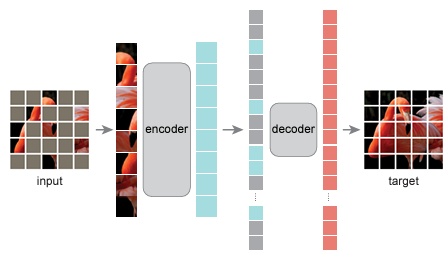

**Figure 1**: MAE architeture

## Imports, functions and data

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import random

2024-09-26 00:09:24.640447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 00:09:24.660660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 00:09:24.666779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 00:09:25.599623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
def time_elapsed(start_time, finish_time):
  minutes = int((finish_time-start_time)/60)
  sec = round((finish_time-start_time)%60,2)
  print("The task took ", minutes, "min," , sec, "sec")

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float16") / 255
x_test = np.expand_dims(x_test, -1).astype("float16") / 255

# Split the dataset

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [ ]:
print("X_train, train dataset:", x_train.shape)
print("X_val, validation dataset:", x_val.shape)
print("X_test, test datataset:", x_test.shape)

X_train, train dataset: (51000, 28, 28, 1)
X_val, validation dataset: (9000, 28, 28, 1)
X_test, test datataset: (10000, 28, 28, 1)


## Patches: creation, encoding, and embedding

In [ ]:
# Variables used in the code below.

#  Patches
PATCH_SIZE = 4

#  Patch Encoder
ENC_PROJECTION_DIM = 32
DEC_PROJECTION_DIM = 16
MASK_PROPORTION = 0.75
NUM_PATCHES = int(x_train.shape[1] / PATCH_SIZE) * int(x_train.shape[2] / PATCH_SIZE)
NUM_PATCHES_MASKED = int(MASK_PROPORTION * NUM_PATCHES)
NUM_PATCHES_UNMASKED = NUM_PATCHES - NUM_PATCHES_MASKED



The first step is to create a class based on layers that receives a batch of images and divides them into patches.
There are also two auxiliary functions that can be used with the patches: one that allows the display of a patched image and another that allows the reconstruction of the image.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Patches(tf.keras.Model):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # If the image has three channels use here to resize each patch
        # (patch_size * patch_size * 3).
        self.resize = layers.Reshape((-1, self.patch_size * self.patch_size))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.

        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 1))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 1))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Usage of the 'show_patched_image' function:
Index selected: 141.


2024-09-26 00:09:29.578600: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


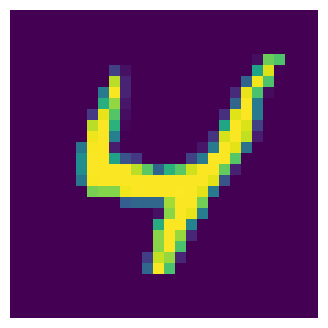

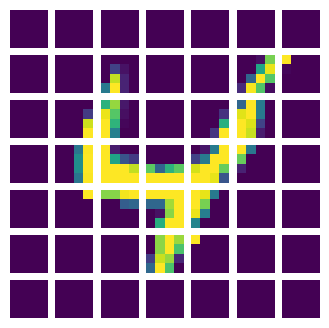

Image obtained from 'reconstruct_from_patch' function:


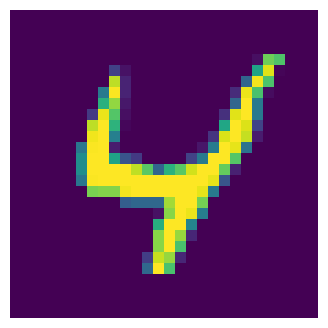

In [ ]:
# Example of usage.

# Get a batch of images.
image = x_train[0:200]

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(image)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.

print("Usage of the 'show_patched_image' function:")
random_index = patch_layer.show_patched_image(image, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])

print("Image obtained from 'reconstruct_from_patch' function:")
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

The second class (also based on layers) is more complex. It receives a batch of patches and generates a batch of five data items.

The patches are processed through a dense layer, and the positional indexes (in our example, numbers from 0 to 48, one for each patch) pass through an embedding layer. The final dimensions for both processes are defined in the variable ENC_PROJECTION_DIM.

Randomly, based on the MASK_PROPORTION variable, the class divides the data into two categories: masked and unmasked.

The class also creates a mask token, initialized randomly from a normal distribution. This token is used to replace the patches that will be masked.

The patches projected through the dense layer are summed with the positional embedding.

In the end, the class provides batches of these five tensors:

* **unmasked_embeddings**: projection of unmasked patches added to positional embedding.
* **masked_embeddings**: projection of masked tokens added to positional embedding.
* **unmasked_positions**: embedding of unmasked positional information.
* **mask_indices**: indexes of masked patches.
* **unmasked_indices**: indexes of unmasked patches.

The class also has an auxiliary function that receives a patch and the unmasked indexes and plots the masked image.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchEncoder(tf.keras.Model):
    def __init__(
        self,
        num_patches = NUM_PATCHES,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a mask token initialized randomly from a normal
        # distribution.
        self.mask_token = self.add_weight(
             name='mask_token',
             shape=(1, self.patch_size * self.patch_size),
             initializer=tf.random_normal_initializer(),
             trainable=False
        )
        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=self.projection_dim
        )


    def build(self, input_shape):
        (self.batch, self.num_patches, self.patch_area) = input_shape


        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        num_patches = tf.shape(patches)[1]

        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        if not tf.executing_eagerly():
          new_patch = tf.zeros_like(patch)
        else:
          new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

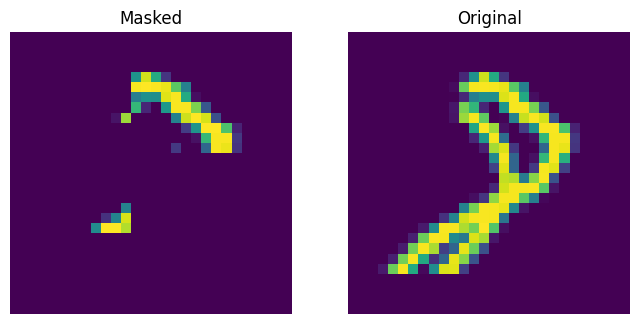

In [ ]:
# Example of usage.

# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = x_train[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [ ]:
print("unmasked_embeddings shape (Batch, Number of unmasked patches, ENC_PROJECTION_DIM): ", unmasked_embeddings.shape)
print("masked_embeddings shape (Batch, Number of masked patches, ENC_PROJECTION_DIM): ", masked_embeddings.shape)
print("unmasked_positions shape (Batch, Number of unmasked patches, ENC_PROJECTION_DIM): ", unmasked_positions.shape)
tf.print("mask_indices of one sample: ", mask_indices[0], " - length:", mask_indices[0].shape[0])
tf.print("unmask_indices of one sample: ", unmask_indices[0], " - length:", unmask_indices[0].shape[0])

unmasked_embeddings shape (Batch, Number of unmasked patches, ENC_PROJECTION_DIM):  (200, 13, 32)
masked_embeddings shape (Batch, Number of masked patches, ENC_PROJECTION_DIM):  (200, 36, 32)
unmasked_positions shape (Batch, Number of unmasked patches, ENC_PROJECTION_DIM):  (200, 13, 32)
mask_indices of one sample:  [30 35 16 ... 3 33 14]  - length: 36
unmask_indices of one sample:  [48 47 4 ... 34 8 29]  - length: 13


## Masked Autoencoder Model

The encoder and decoder used in the model architecture shown in **Figure 1** follow a transformer structure similar to the image below, except for the Linear and Softmax layers shown above the image.

<center>


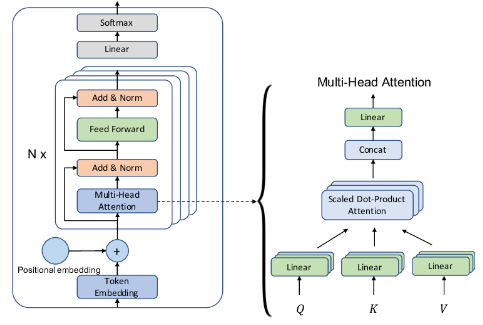

**Figure 2**: Transformer structure and multi-head attention cell. [3]
</center>

[3] [https://www.researchgate.net/figure/Transformer-structure-and-multi-head-attention-cell-The-feed-forward-layer-and-all_fig1_369116183](https://www.researchgate.net/figure/Transformer-structure-and-multi-head-attention-cell-The-feed-forward-layer-and-all_fig1_369116183)

In [ ]:
# Variables used in the code below.

IMAGE_SIZE = 28
ENC_NUM_HEADS = 1
ENC_LAYERS = 2
DEC_NUM_HEADS = 1
DEC_LAYERS = 1

ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

LAYER_NORM_EPS = 1e-6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

BATCH_SIZE= 32
EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
# Fully connected feed forward network of the transformer architecture
@tf.keras.utils.register_keras_serializable()
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# The MAE encoder is ViT. The only point to note here is that the encoder
# outputs a layer normalized output.
@tf.keras.utils.register_keras_serializable()
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((NUM_PATCHES_UNMASKED, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
            )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


In [ ]:
@tf.keras.utils.register_keras_serializable()
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 1, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 1))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


For the model, we use a `tf.keras.Model` class and wrap the encoder and decoder inside it.

An important point of the model is that it trains with the visible patches as input, but the loss function uses the masked patches (the information under the masked patches) to calculate the backpropagation.

Thus, the loss is measured by considering the difference between the patches generated by the model and the original ones at the masked positions.

The model's performance is measured using the difference between the patches generated by the model and the original ones at all positions.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        Xtrain=None,
        Xtest=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.Xtrain = Xtrain
        self.Xtest = Xtest
        self.patch_layer = Patches()
        self.patch_encoder = PatchEncoder()
        self.encoder = create_encoder()
        self.decoder = create_decoder()

    def call(self, images):
        patches = self.patch_layer(images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        #return decoder_patches
        return decoder_outputs

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            images = self.Xtest
        else:
            images = self.Xtrain

        # Patch the images.
        patches = self.patch_layer(images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)


        # Decoder the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)
        total_loss2 = self.compute_loss(y=patches, y_pred=decoder_patches)

        return total_loss, patches, decoder_patches, total_loss2

    def train_step(self, images):
        with tf.GradientTape() as tape:

            total_loss, patches, decoder_patches, total_loss2 = self.calculate_loss(images)


            # Apply gradients.
            train_vars = (
                #self.patch_layer.trainable_variables +
                self.patch_encoder.trainable_variables +
                self.encoder.trainable_variables +
                self.decoder.trainable_variables
            )
            grads = tape.gradient(total_loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # Report progress.
        results = {}
        for metric in self.metrics:
          metric.update_state(patches, decoder_patches)
          #results[metric.name] = metric.result()
        results["loss - MSE"] = total_loss
        results["Reconstruction - MSE"] = total_loss2
        return results

    def test_step(self, images):
        total_loss, patches, decoder_patches, total_loss2 = self.calculate_loss(images[0], test=True)
        # Update the trackers.
        results = {}
        for metric in self.metrics:
            metric.update_state(patches, decoder_patches)
            #results[metric.name] = metric.result()
        results["loss - MSE"] = total_loss
        results["Reconstruction - MSE"] = total_loss2
        return results


We also define a `keras.callbacks` class to help monitor the model's progress.

In [ ]:
# Taking a batch of test inputs to measure model's progress.

class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            lenght = len(self.model.Xtest)
            image_idx = random.randint(0,lenght-1)
            test_images = self.model.Xtest[image_idx]
            test_patches = self.model.patch_layer(test_images.reshape(1,28,28,1))
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)
            test_decoder_patches = self.model.patch_layer(test_decoder_outputs)

            #####
            test_unmasked_patch, idx = self.model.patch_encoder.generate_masked_image(
                            test_patches, test_mask_indices
                        )

            unmasked_image = self.model.patch_layer.reconstruct_from_patch(
                test_unmasked_patch
            )
            test_unmasked_output, idx = self.model.patch_encoder.generate_masked_image(
                            test_decoder_patches, test_mask_indices
                        )

            unmasked_output = self.model.patch_layer.reconstruct_from_patch(
                test_unmasked_output
            )
            #####

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            #print(f"\nIdx chosen: {idx}")
            original_image = test_images
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(25, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original")
            ax[0].axis("off")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked")
            ax[1].axis("off")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Reconstructed")
            ax[2].axis("off")

            ax[3].imshow(unmasked_image)
            ax[3].set_title(f"Under mask (UM)")
            ax[3].axis("off")

            ax[4].imshow(unmasked_output)
            ax[4].set_title(f"Under mask reconstructed (UMR)")
            ax[4].axis("off")

            ax[5].imshow(abs(unmasked_output - unmasked_image))
            ax[5].set_title(f"Diff: UM/UMR")
            ax[5].axis("off")

            plt.show()
            plt.close()


## Training the Model

In [ ]:
# Create the model

mae_model = MaskedAutoencoder(
    Xtrain =x_train,
    Xtest = x_val
)

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE)

# Compile the model.
mae_model.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics= [keras.metrics.MeanSquaredError()])

train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/20


I0000 00:00:1727320192.507905 2884090 service.cc:146] XLA service 0x7fdbc4009d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727320192.508041 2884090 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2024-09-26 00:09:53.813697: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. patch_encoder_1_1/random_uniform/RandomUniform
I0000 00:00:1727320210.002059 2884090 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - Reconstruction - MSE: 0.0469 - loss - MSE: 0.0494

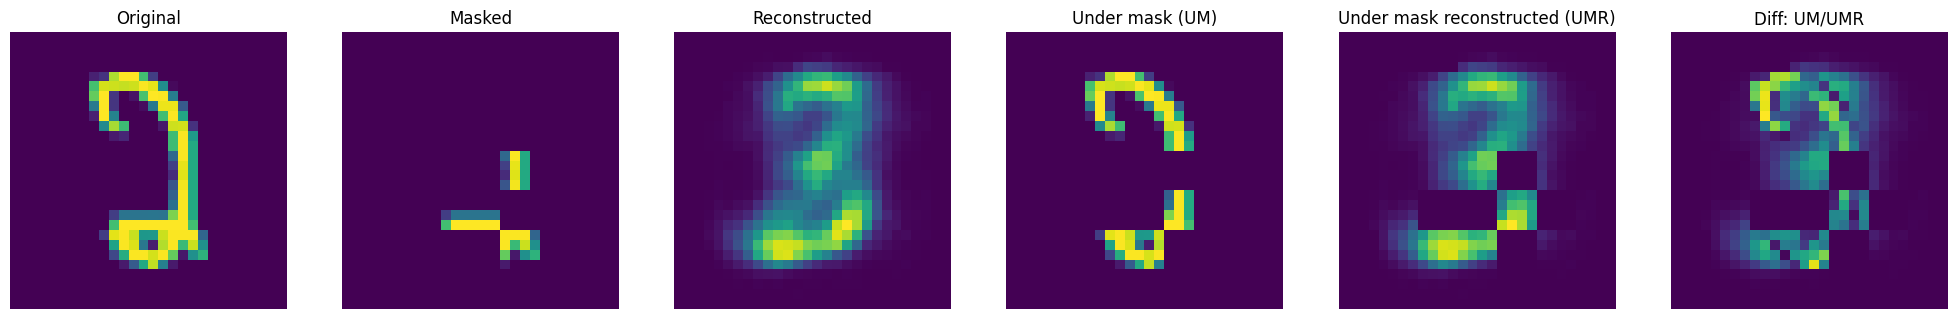

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 273s 149ms/step - Reconstruction - MSE: 0.0469 - loss - MSE: 0.0494 - val_Reconstruction - MSE: 0.0395 - val_loss - MSE: 0.0426
Epoch 2/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 213s 134ms/step - Reconstruction - MSE: 0.0375 - loss - MSE: 0.0407 - val_Reconstruction - MSE: 0.0363 - val_loss - MSE: 0.0395
Epoch 3/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0353 - loss - MSE: 0.0385 - val_Reconstruction - MSE: 0.0347 - val_loss - MSE: 0.0379
Epoch 4/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0341 - loss - MSE: 0.0375 - val_Reconstruction - MSE: 0.0338 - val_loss - MSE: 0.0372
Epoch 5/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0334 - loss - MSE: 0.0368 - val_Reconstruction - MSE: 0.0332 - val_loss - MSE: 0.0366
Epoch 6/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - Reconstruction - MSE: 0.0329 - loss - MSE: 0.0364

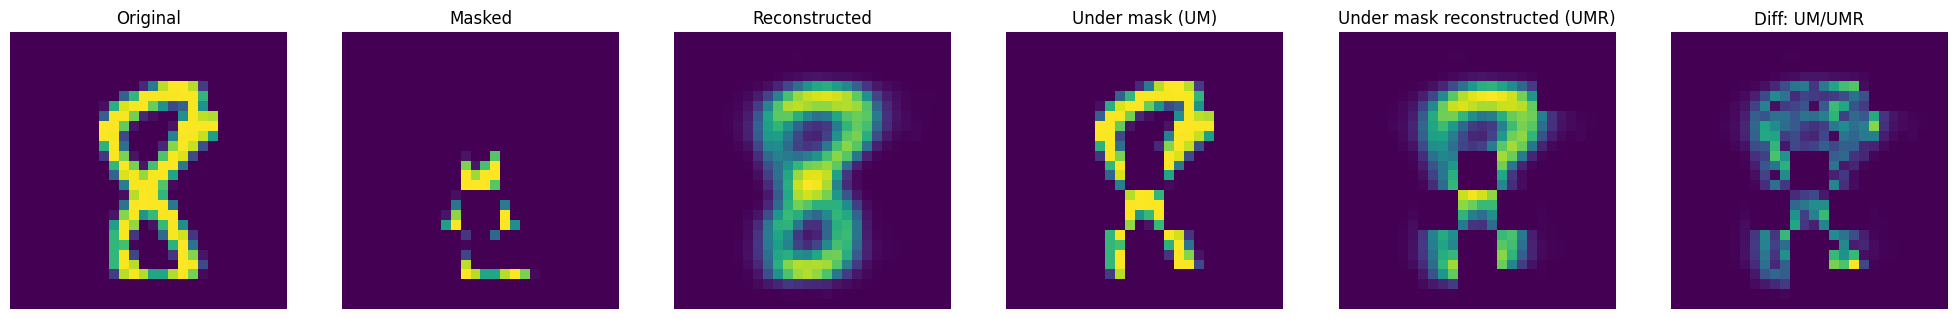

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 206s 129ms/step - Reconstruction - MSE: 0.0329 - loss - MSE: 0.0364 - val_Reconstruction - MSE: 0.0328 - val_loss - MSE: 0.0362
Epoch 7/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0326 - loss - MSE: 0.0360 - val_Reconstruction - MSE: 0.0324 - val_loss - MSE: 0.0359
Epoch 8/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0323 - loss - MSE: 0.0357 - val_Reconstruction - MSE: 0.0323 - val_loss - MSE: 0.0357
Epoch 9/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0320 - loss - MSE: 0.0355 - val_Reconstruction - MSE: 0.0320 - val_loss - MSE: 0.0354
Epoch 10/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0318 - loss - MSE: 0.0353 - val_Reconstruction - MSE: 0.0318 - val_loss - MSE: 0.0354
Epoch 11/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - Reconstruction - MSE: 0.0316 - loss - MSE: 0.0351

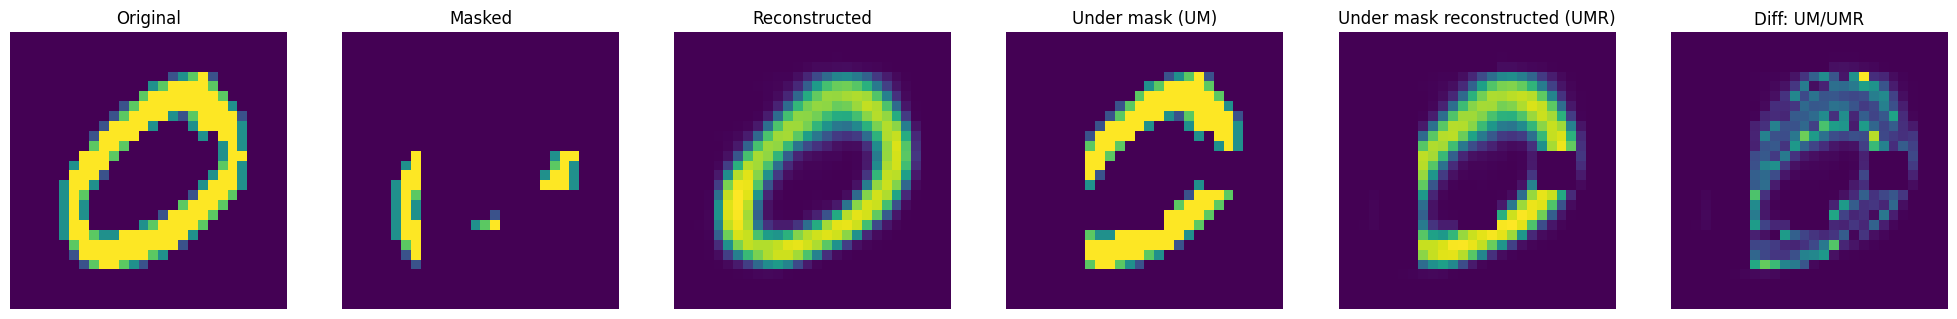

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0316 - loss - MSE: 0.0351 - val_Reconstruction - MSE: 0.0316 - val_loss - MSE: 0.0351
Epoch 12/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0315 - loss - MSE: 0.0350 - val_Reconstruction - MSE: 0.0315 - val_loss - MSE: 0.0350
Epoch 13/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0314 - loss - MSE: 0.0349 - val_Reconstruction - MSE: 0.0313 - val_loss - MSE: 0.0348
Epoch 14/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0312 - loss - MSE: 0.0347 - val_Reconstruction - MSE: 0.0313 - val_loss - MSE: 0.0348
Epoch 15/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0311 - loss - MSE: 0.0347 - val_Reconstruction - MSE: 0.0312 - val_loss - MSE: 0.0348
Epoch 16/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - Reconstruction - MSE: 0.0310 - loss - MSE: 0.0346

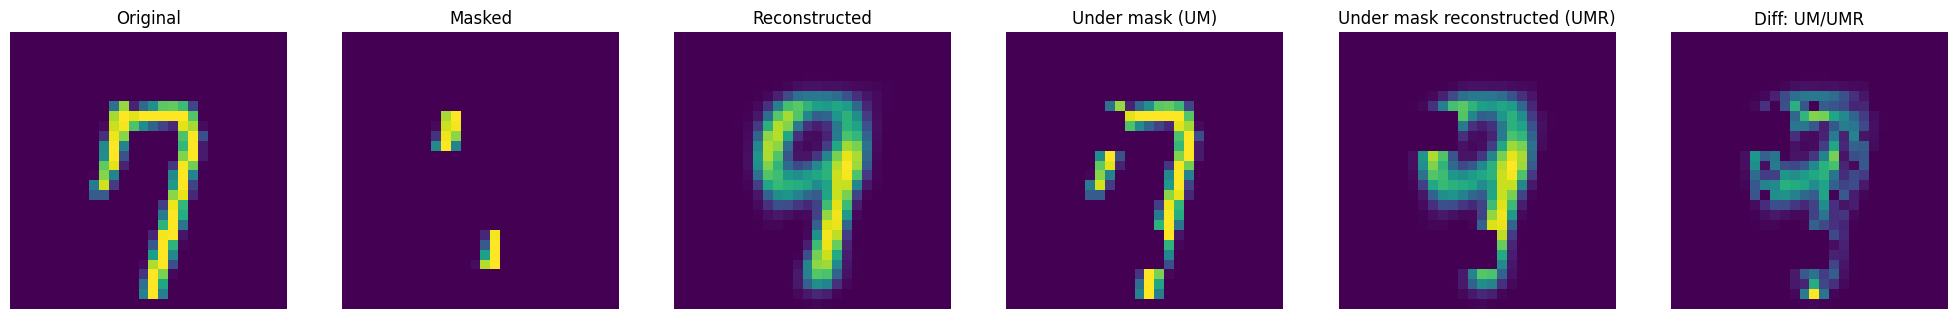

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0310 - loss - MSE: 0.0346 - val_Reconstruction - MSE: 0.0311 - val_loss - MSE: 0.0346
Epoch 17/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0309 - loss - MSE: 0.0345 - val_Reconstruction - MSE: 0.0311 - val_loss - MSE: 0.0347
Epoch 18/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0309 - loss - MSE: 0.0344 - val_Reconstruction - MSE: 0.0309 - val_loss - MSE: 0.0344
Epoch 19/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0308 - loss - MSE: 0.0343 - val_Reconstruction - MSE: 0.0310 - val_loss - MSE: 0.0346
Epoch 20/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - Reconstruction - MSE: 0.0307 - loss - MSE: 0.0342 - val_Reconstruction - MSE: 0.0307 - val_loss - MSE: 0.0343

  done
The task took  69 min, 40.78 sec


In [ ]:
# Train the model

start_time = time.time()

with tf.device("/gpu:0"):
  try:

    history = mae_model.fit(
    x_train,
    epochs=EPOCHS, batch_size= BATCH_SIZE,
    validation_data=(x_val[0:500], x_val[0:500]),
    callbacks=[train_callbacks]
    )

  except KeyboardInterrupt:
    print('\n  interrupted')
    history = mae_model.history
    finish_time = time.time()
    time_elapsed(start_time, finish_time)
  else:
    print('\n  done')

finish_time = time.time()

time_elapsed(start_time, finish_time)

-----

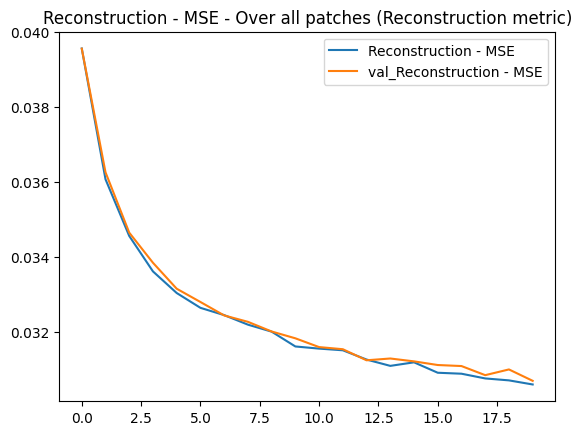

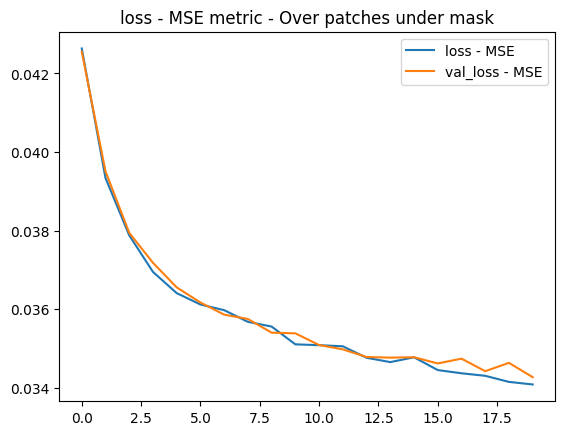

In [ ]:
for key in history.history.keys():
  if key[0:3] != "val":
    plt.plot(history.history[key],  label=key)
    plt.plot(history.history["val_"+str(key)],  label="val_"+str(key))
    if key[0:4] == "loss":
      plt.title(key + " metric - Over patches under mask")
    else:
      plt.title(key  + " - Over all patches (Reconstruction metric)")
    plt.legend()
    plt.show()

## Understanding the Model

The encoder structure is designed to receive input in the format (None, NUM_PATCHES_MASKED, ENC_PROJECTION_DIM), so it's adaptive to batch size.

In [ ]:
# Encoder structure

mae_model.encoder.summary()

Model: "mae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 13, 32)    │         64 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 32)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 13, 64)    │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 13, 32)    │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 13, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 13, 32)    │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 13, 32)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 32)    │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 13, 64)    │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 13, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 13, 32)    │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 13, 32)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 13, 32)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,152 (67.00 KB)

 Trainable params: 17,152 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

The decoder structure is designed to receive input in the format (None, NUM_PATCHES, ENC_PROJECTION_DIM), so it's adaptive to batch size and fixed with respect to the total number of patches.

In [ ]:
# Decoder structure

mae_model.decoder.summary()

Model: "mae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 49, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 49, 16)    │        528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 16)    │         32 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 16)    │      1,088 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 49, 16)    │          0 │ multi_head_atten… │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 16)    │         32 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 49, 32)    │        544 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 49, 32)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 49, 16)    │        528 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 49, 16)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 49, 16)    │          0 │ dropout_8[0][0],  │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 16)    │         32 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 784)       │    615,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 618,224 (2.36 MB)

 Trainable params: 618,224 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Let's see, step by step, what happens inside the model using only one image as an example.

In [ ]:
# Pick a random image from the test dataset
# Resize it to the shape (1, 28, 28, 1)

lenght = len(x_test)
image_idx = random.randint(0,lenght-1)
image_example = x_test[image_idx]
image_example = image_example.reshape(1,28,28,1)

print(image_example.shape)

(1, 28, 28, 1)


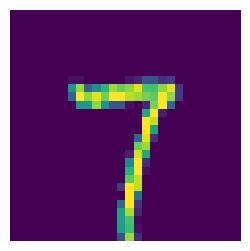

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow(image_example[0])
plt.axis("off")
plt.show()

In [ ]:
# Inside the model, a layer using the Patches() class is created
# and applied to the image, generating the patches.

patches_example = mae_model.patch_layer(image_example)

print("Patches shape:", patches_example.shape)
print("--------")

# Using the PatchEncoder() class, the patches are processed, and
# the masking and embedding data are generated.

(
    unmasked_embeddings_example,
    masked_embeddings_example,
    unmasked_positions_example,
    mask_indices_example,
    unmask_indices_example,
) = mae_model.patch_encoder(patches=patches_example)


print("Unmasked embeddings tensor shape:", unmasked_embeddings_example.shape)
print("Masked embeddings tensor shape:", masked_embeddings_example.shape)
print("Unmasked position embeddings tensor shape:",unmasked_positions_example.shape)
print("Masked patches indexes shape:",mask_indices_example.shape)
print("Unmasked patches indexes shape:", unmask_indices_example.shape)

print("--------")
tf.print("Masked indexes:",mask_indices_example[0], " - length:",mask_indices_example[0].shape[0])
tf.print("Unmasked indexes:", unmask_indices_example[0] , " - length:", unmask_indices_example[0].shape[0])



Patches shape: (1, 49, 16)
--------
Unmasked embeddings tensor shape: (1, 13, 32)
Masked embeddings tensor shape: (1, 36, 32)
Unmasked position embeddings tensor shape: (1, 13, 32)
Masked patches indexes shape: (1, 36)
Unmasked patches indexes shape: (1, 13)
--------
Masked indexes: [31 2 36 ... 0 28 39]  - length: 36
Unmasked indexes: [35 6 15 ... 4 43 3]  - length: 13


In [ ]:
# The unmasked embeddings are passed through the encoder.
# These embeddings are the result of a projection of the patches that have
# already been added to the positional embedding.
# The output is a tensor with the number of unmasked patches, with each
# patch dimension associated with a vector of the embedding size.

print("Encoder output shape:", mae_model.encoder(unmasked_embeddings_example).shape)

Encoder output shape: (1, 13, 32)


In [ ]:
# The model then adds the result of the encoder for the unmasked patches
# with the unmasked positional embedding values.

encoder_output_example = mae_model.encoder(unmasked_embeddings_example)
encoder_output_example = encoder_output_example + unmasked_positions_example

# The input to the decoder is the concatenation of the above result and the
# masked patches. These masked patches are normal random distributions for each
# patch that go through the same projection as the unmasked patches and are
# added to the positional embedding of the masked patches.


decoder_input_example= tf.concat([encoder_output_example, masked_embeddings_example], axis=1)

print("Decoder input shape:", decoder_input_example.shape)


Decoder input shape: (1, 49, 32)


Therefore, the input to the decoder will be a complete tensor of image patches, where each patch contains both the image information and its position. The unmasked patches underwent a projection, were added to their respective positional embedding, passed through the encoder, and were again added to the positional embedding. The masked patches were generated randomly, added to their respective positional embedding, and did not pass through the encoder. Both types of patches are concatenated and fed into the decoder.

In [ ]:
# In the end, the result has the shape of the initial input.

print("Decoder output shape:", mae_model.decoder(decoder_input_example).shape)

Decoder output shape: (1, 28, 28, 1)


In [ ]:
# It is the same result as doing it directly.

print("Model output shape:",mae_model(image_example).shape )

Model output shape: (1, 28, 28, 1)


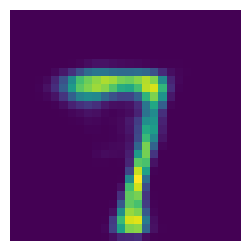

In [ ]:
#The final image

plt.figure(figsize=(3, 3))
plt.imshow(mae_model.decoder(decoder_input_example)[0])
plt.axis("off")
plt.show()

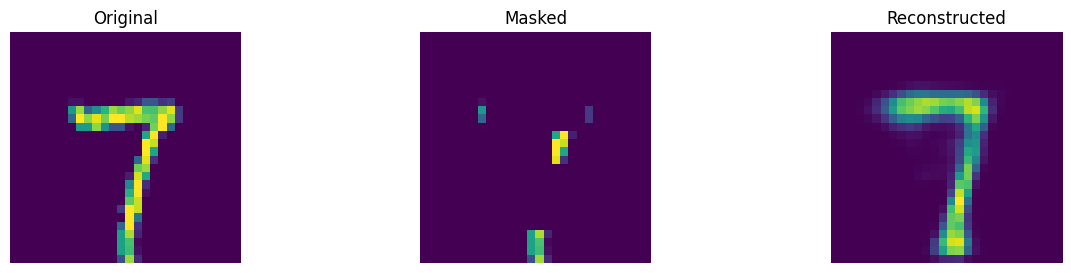

In [ ]:
# Show a masked patch image.
masked_patch_example, idx = mae_model.patch_encoder.generate_masked_image(
    patches_example, unmask_indices_example
)

original_image_example = image_example[0]

masked_image_example = mae_model.patch_layer.reconstruct_from_patch(
    masked_patch_example
)

reconstructed_image_example =  mae_model.decoder(decoder_input_example)[0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
ax[0].imshow(original_image_example)
ax[0].set_title(f"Original")
ax[0].axis("off")

ax[1].imshow(masked_image_example)
ax[1].set_title(f"Masked")
ax[1].axis("off")

ax[2].imshow(reconstructed_image_example)
ax[2].set_title(f"Reconstructed")
ax[2].axis("off")


plt.show()
plt.close()

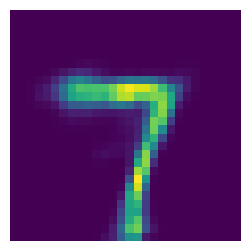

In [ ]:
#The final image

plt.figure(figsize=(3, 3))
plt.imshow(mae_model(image_example)[0])
plt.axis("off")
plt.show()

As the model has an randomness a different sample is generated at each execution. Let's check 5 samples below.

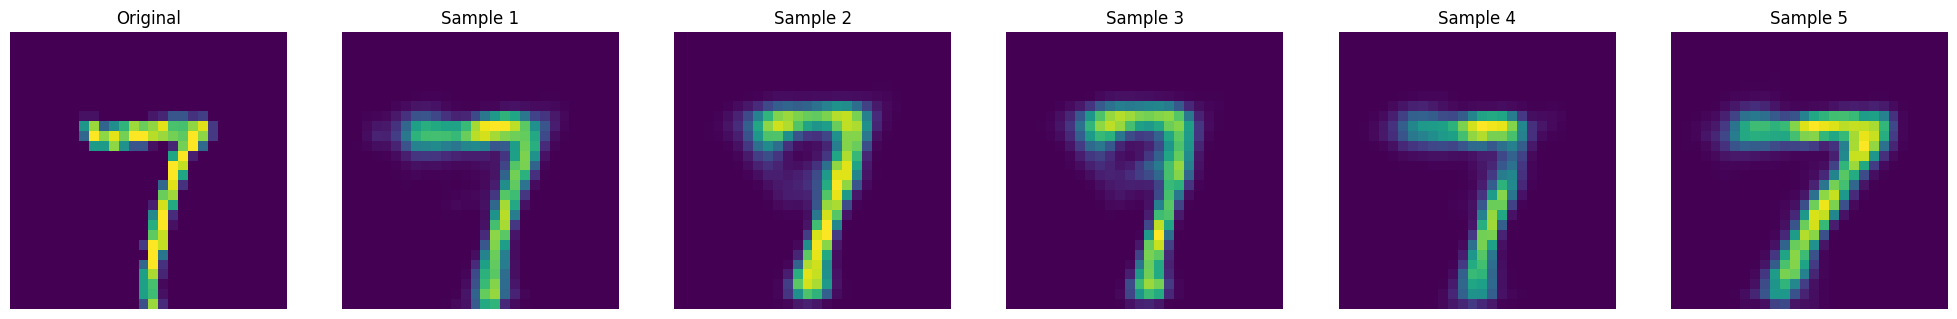

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(25, 5))
lenght = len(x_test)
ax[0].imshow(image_example[0])
ax[0].set_title("Original")
ax[0].axis("off")
for i in range(1,6):
  ax[i].imshow(mae_model(image_example)[0])
  ax[i].set_title("Sample "+  str(i))
  ax[i].axis("off")
plt.show()
plt.close()

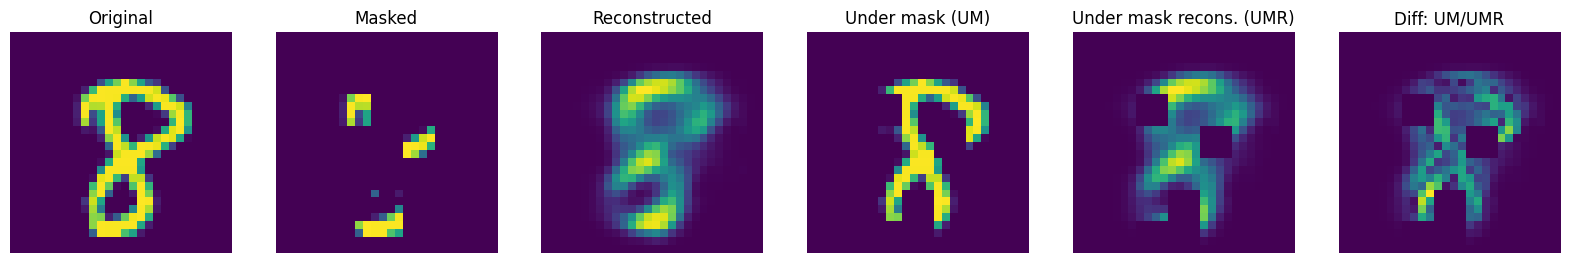

MSE - all patches: 0.0447014198
MSE - under the mask patches: 0.043226853


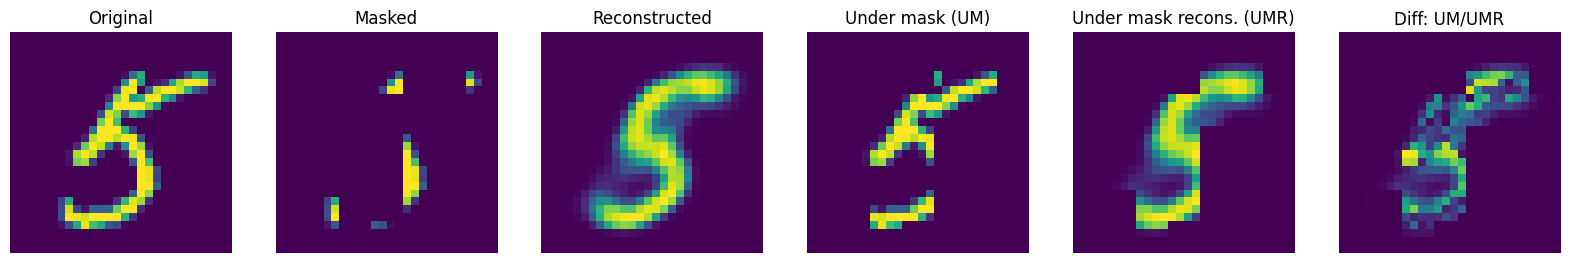

MSE - all patches: 0.0307586044
MSE - under the mask patches: 0.037390098


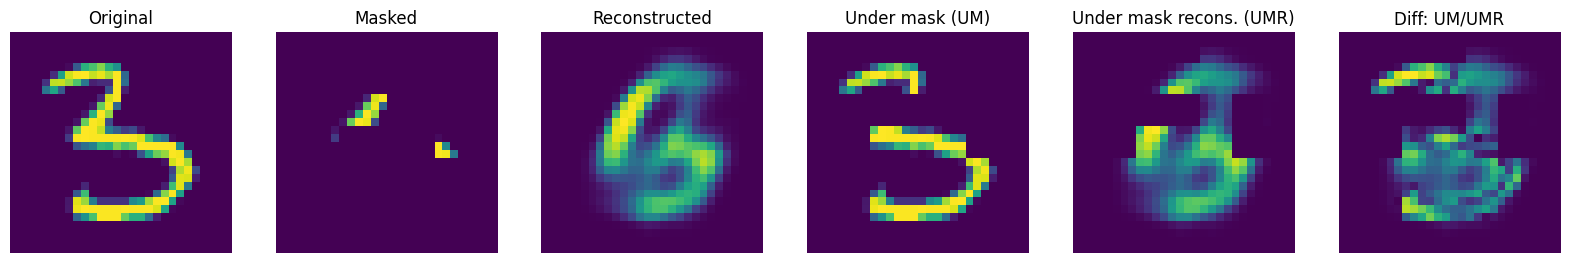

MSE - all patches: 0.0655988902
MSE - under the mask patches: 0.0838881955


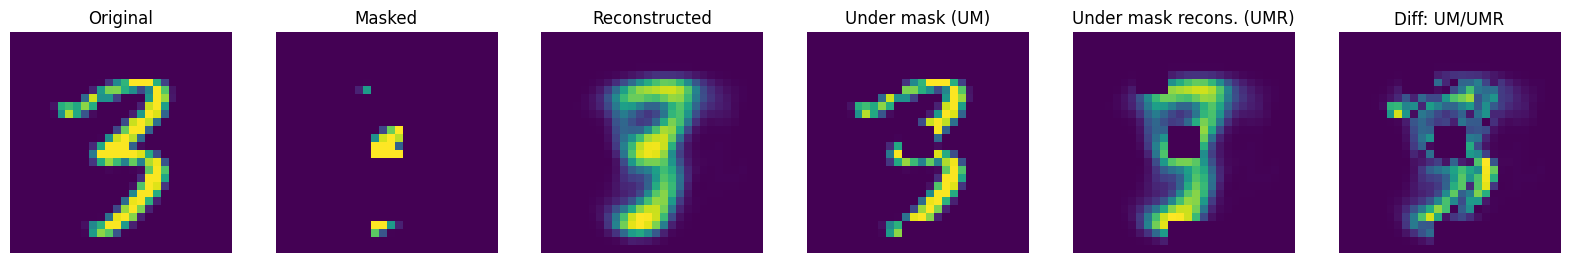

MSE - all patches: 0.0363964476
MSE - under the mask patches: 0.0469801314


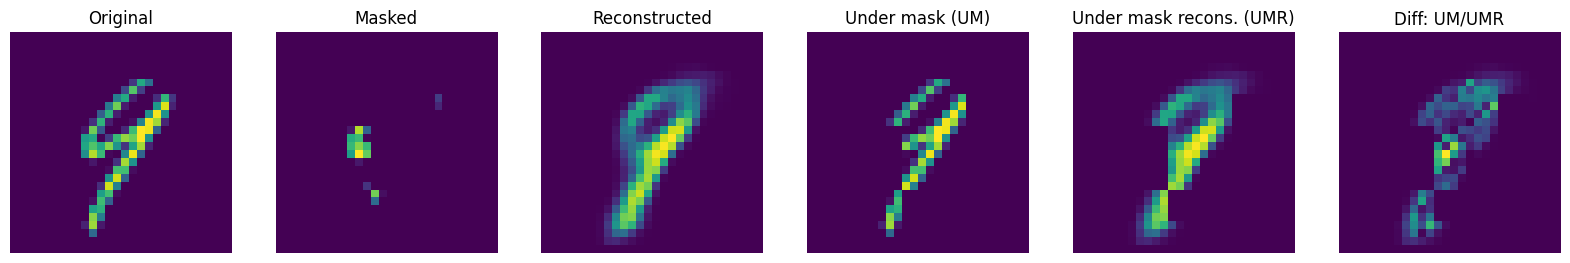

MSE - all patches: 0.0141346138
MSE - under the mask patches: 0.0132217659


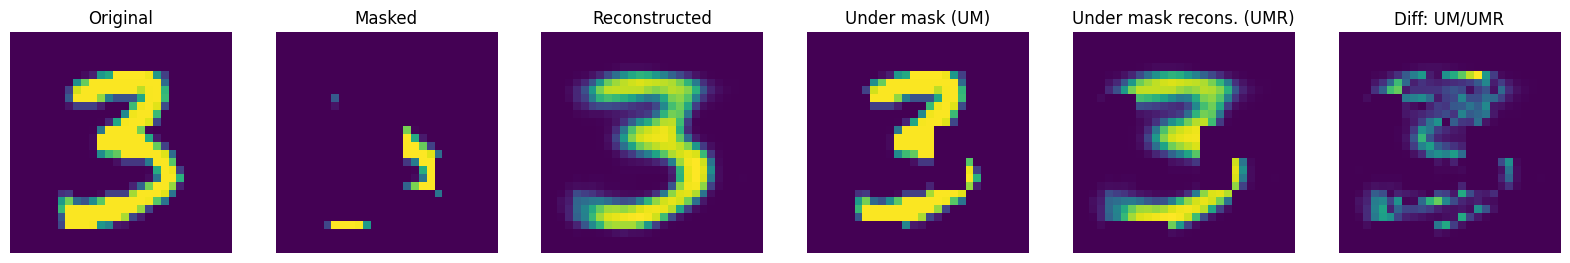

MSE - all patches: 0.0183988512
MSE - under the mask patches: 0.0196359735


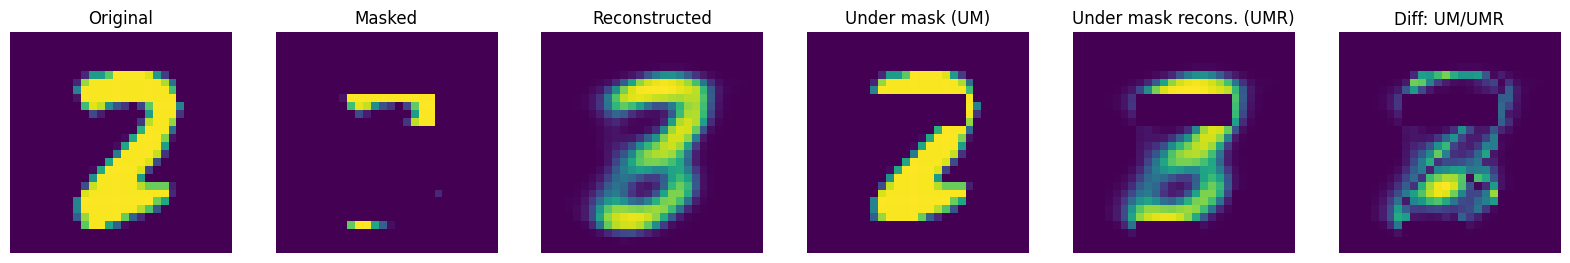

MSE - all patches: 0.0391166247
MSE - under the mask patches: 0.0488983914


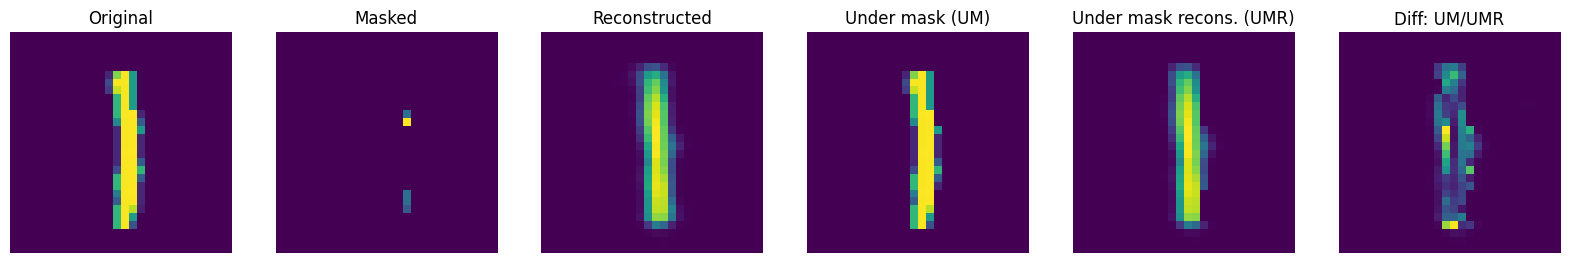

MSE - all patches: 0.00606817054
MSE - under the mask patches: 0.00756444549


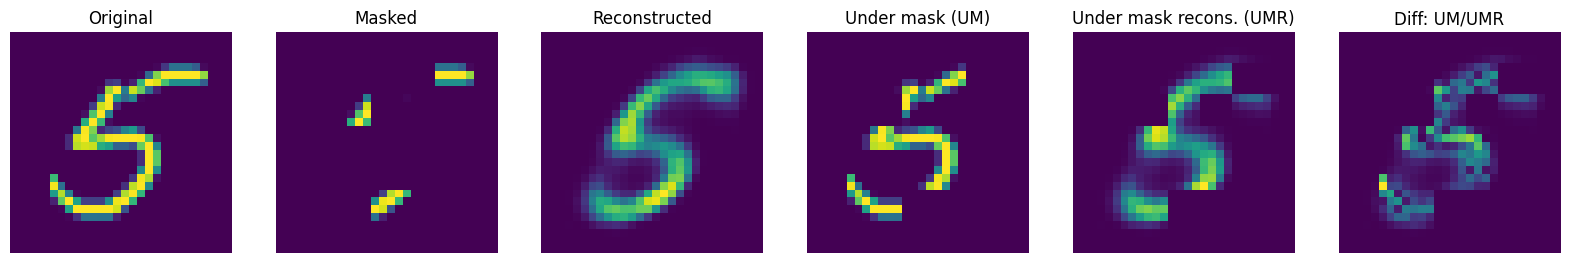

MSE - all patches: 0.0242393557
MSE - under the mask patches: 0.0261708982


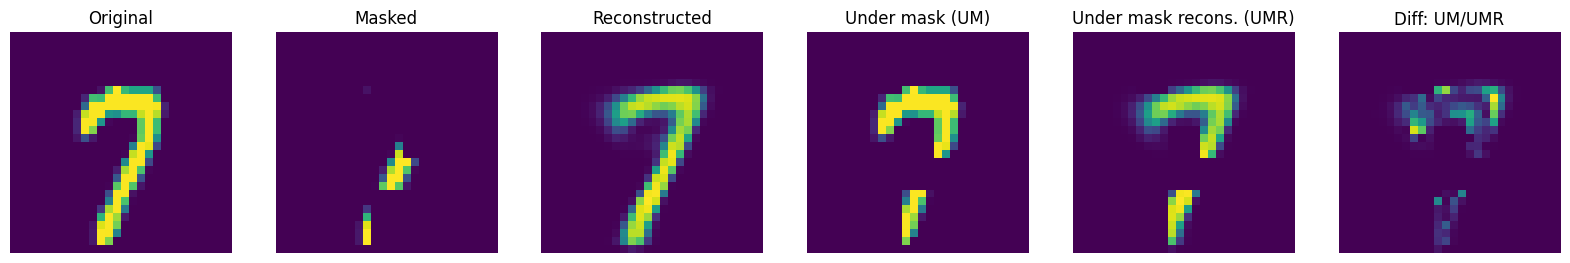

MSE - all patches: 0.010284353
MSE - under the mask patches: 0.0124619585


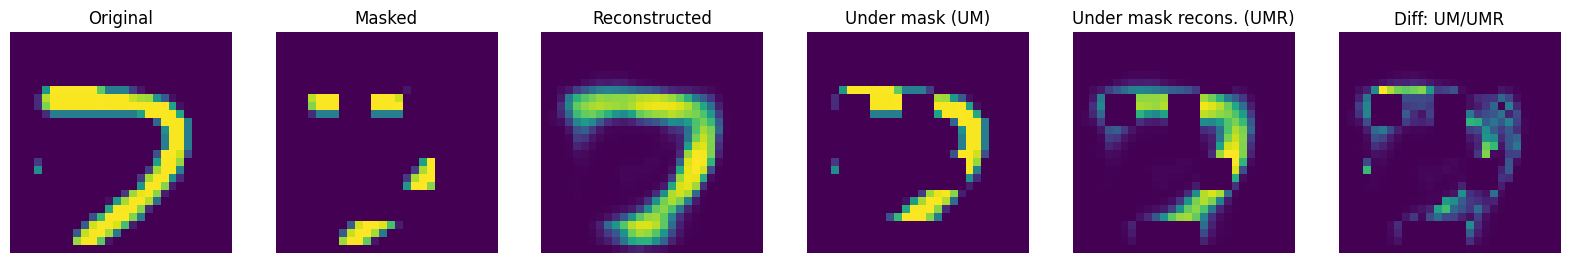

MSE - all patches: 0.0214740038
MSE - under the mask patches: 0.0150188617


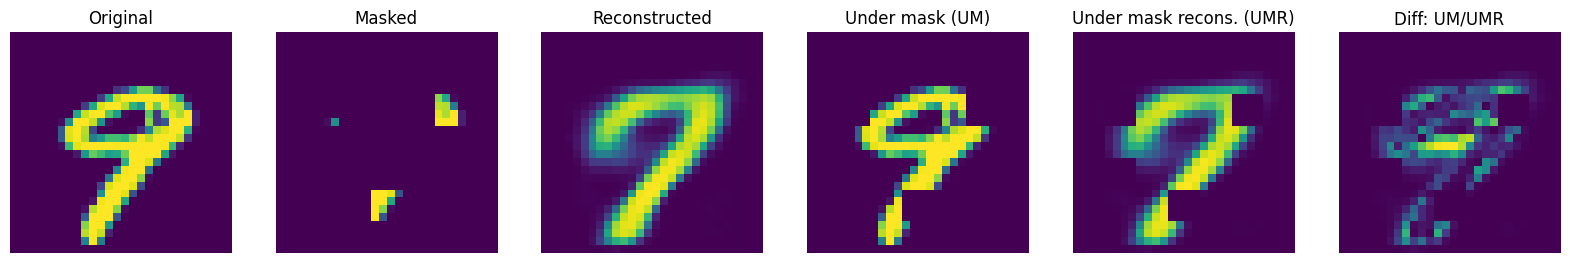

MSE - all patches: 0.0265888851
MSE - under the mask patches: 0.0329892


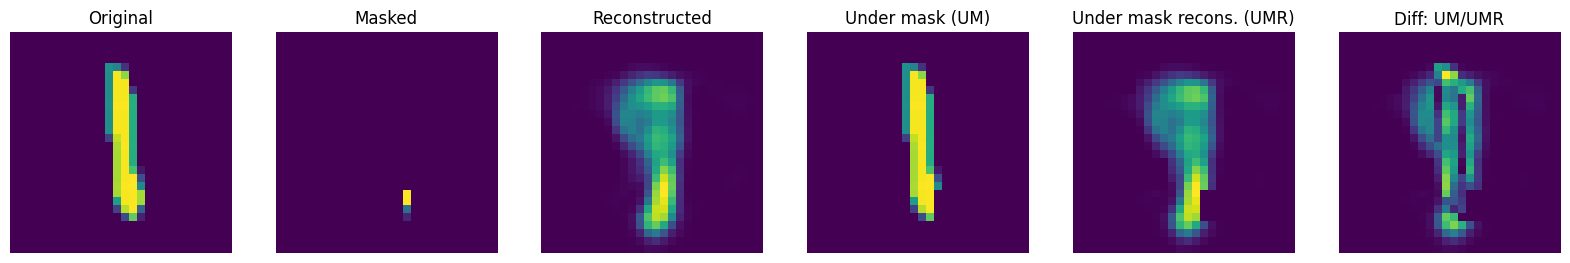

MSE - all patches: 0.0237854719
MSE - under the mask patches: 0.0318187624


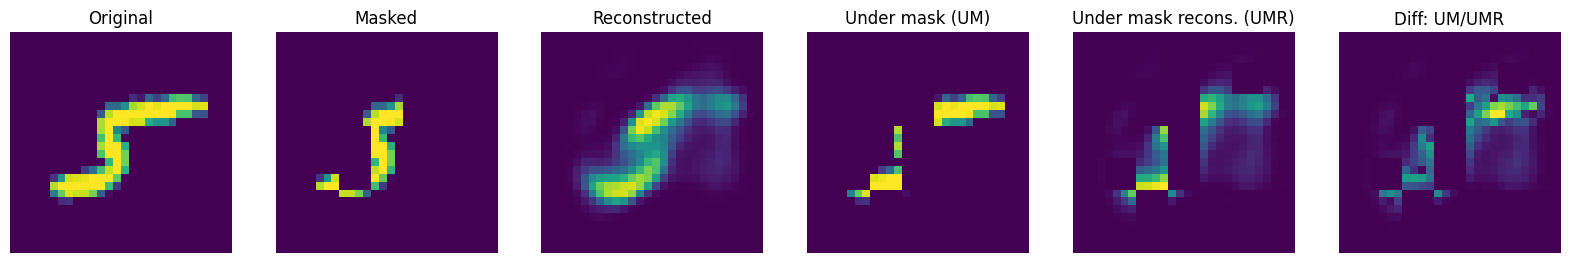

MSE - all patches: 0.0204337388
MSE - under the mask patches: 0.0161941


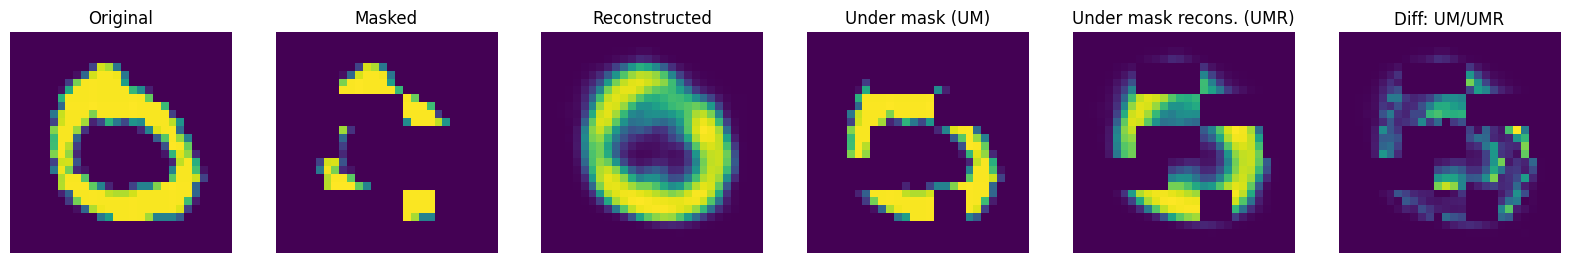

MSE - all patches: 0.0369027592
MSE - under the mask patches: 0.0280343816


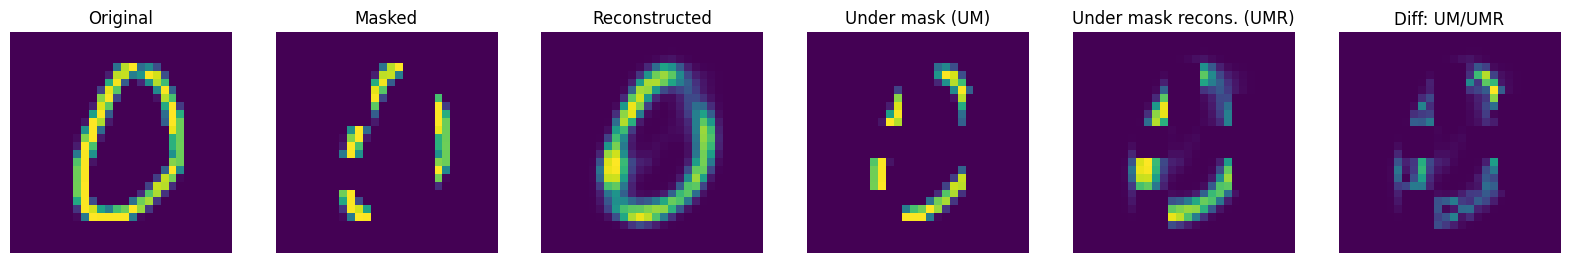

MSE - all patches: 0.0195272546
MSE - under the mask patches: 0.0125687197


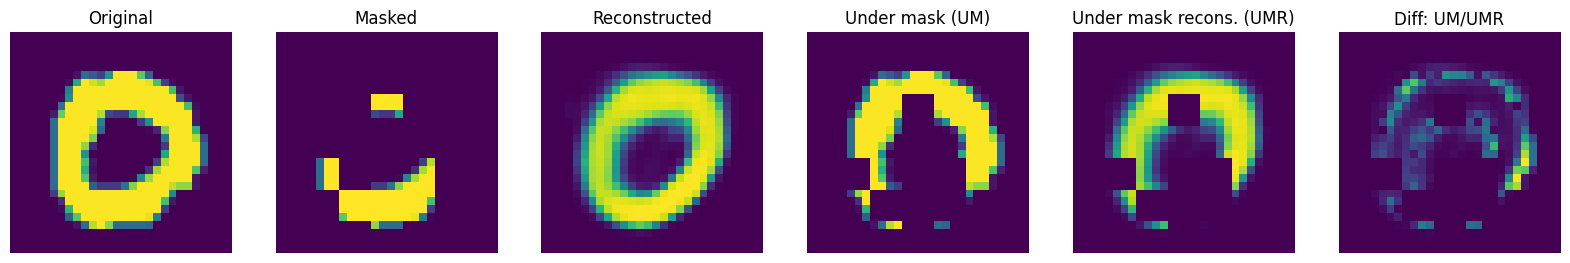

MSE - all patches: 0.0276685692
MSE - under the mask patches: 0.0266241767


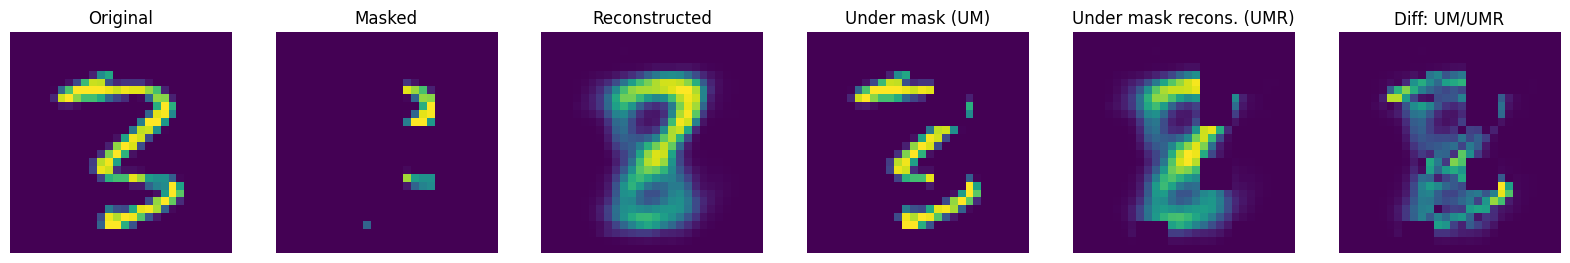

MSE - all patches: 0.0400858708
MSE - under the mask patches: 0.0442475416


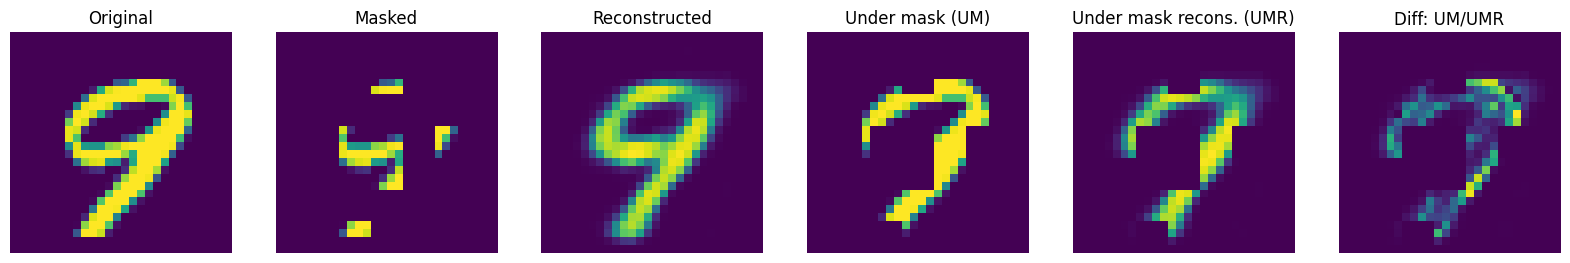

MSE - all patches: 0.0208651144
MSE - under the mask patches: 0.0193955898


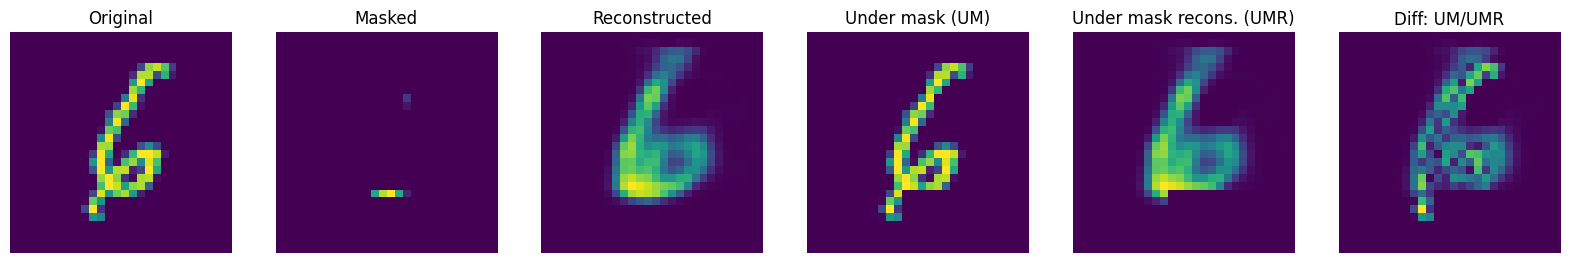

MSE - all patches: 0.0332092829
MSE - under the mask patches: 0.04420726


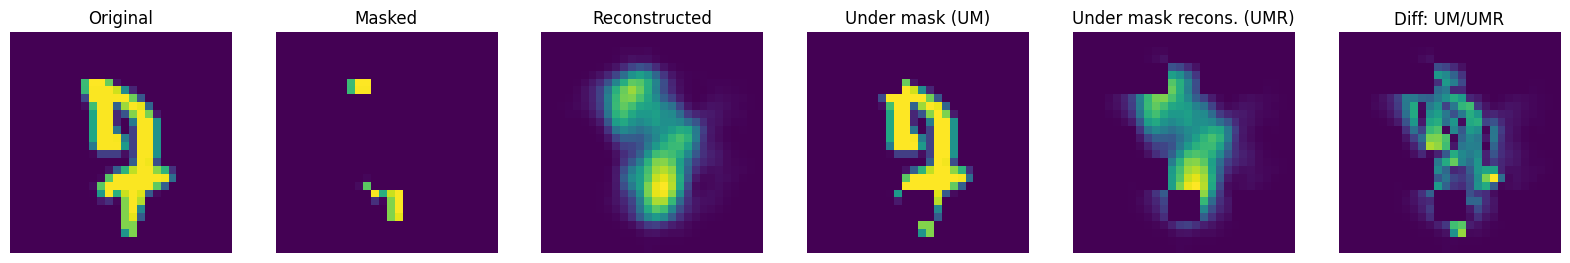

MSE - all patches: 0.0356094055
MSE - under the mask patches: 0.0416779742


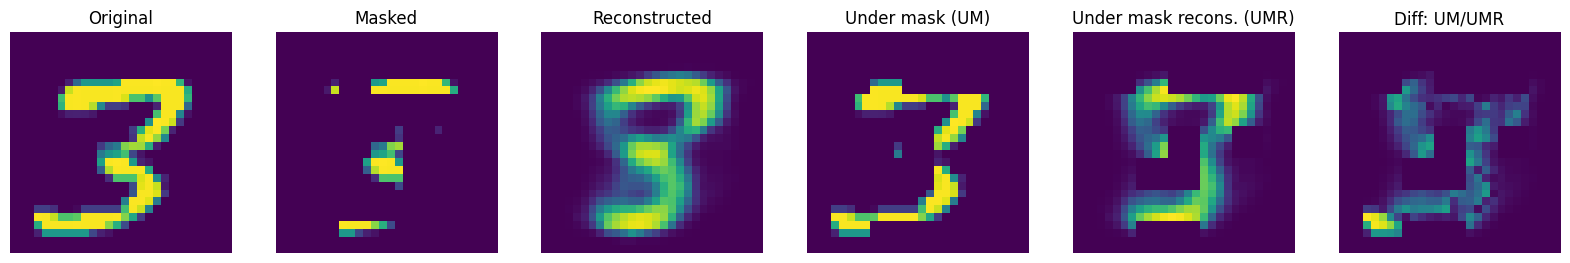

MSE - all patches: 0.0369787179
MSE - under the mask patches: 0.037547417


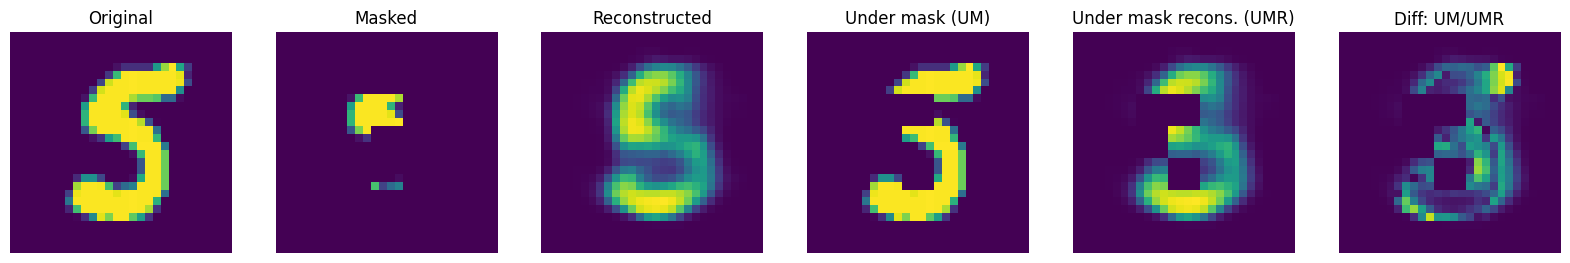

MSE - all patches: 0.0423210785
MSE - under the mask patches: 0.0502017438


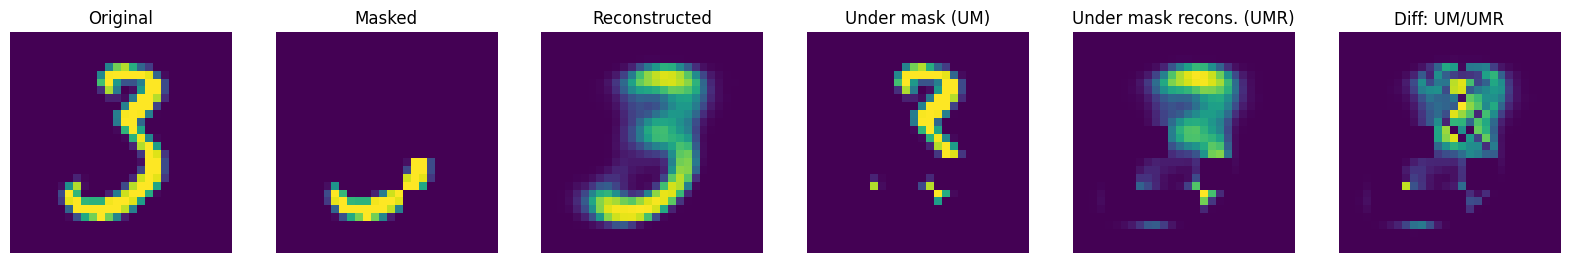

MSE - all patches: 0.0214361642
MSE - under the mask patches: 0.0235952307


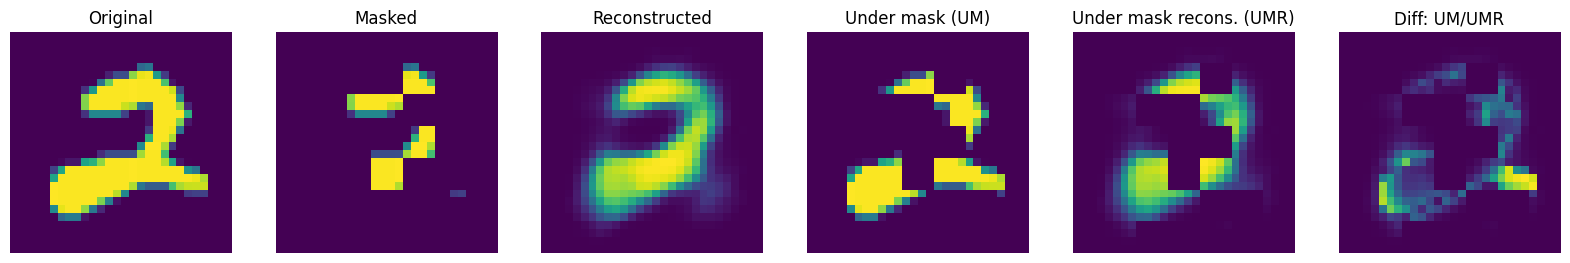

MSE - all patches: 0.0303315967
MSE - under the mask patches: 0.0338755064


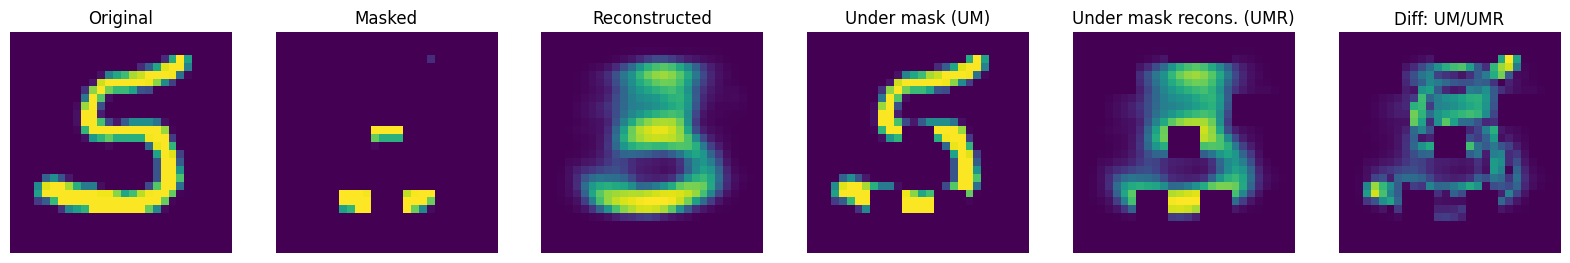

MSE - all patches: 0.0489017479
MSE - under the mask patches: 0.0613025352


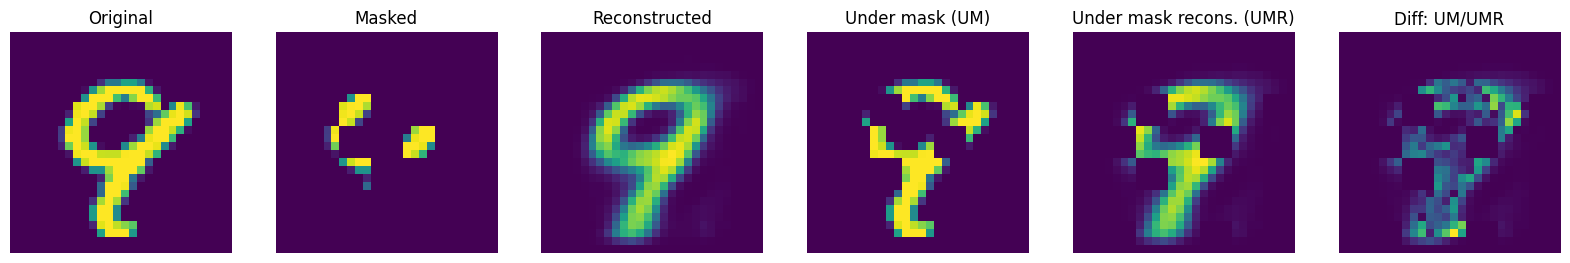

MSE - all patches: 0.0262378622
MSE - under the mask patches: 0.0306611024


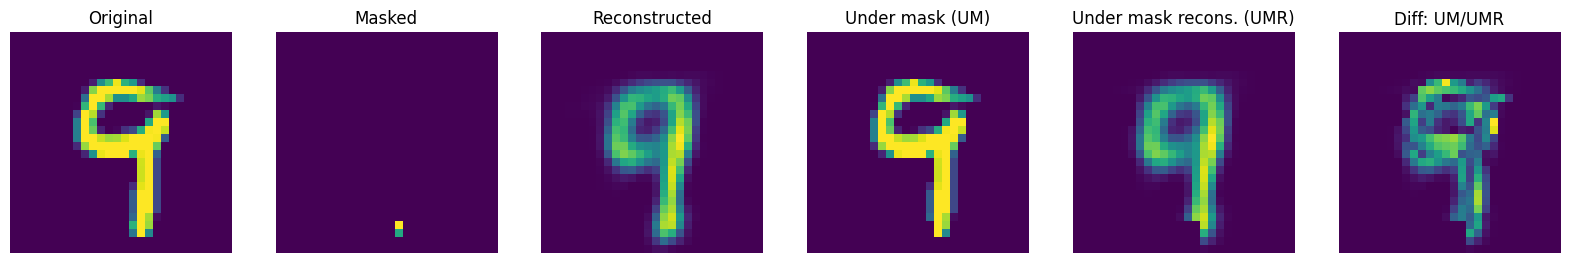

MSE - all patches: 0.0297520235
MSE - under the mask patches: 0.0398828611


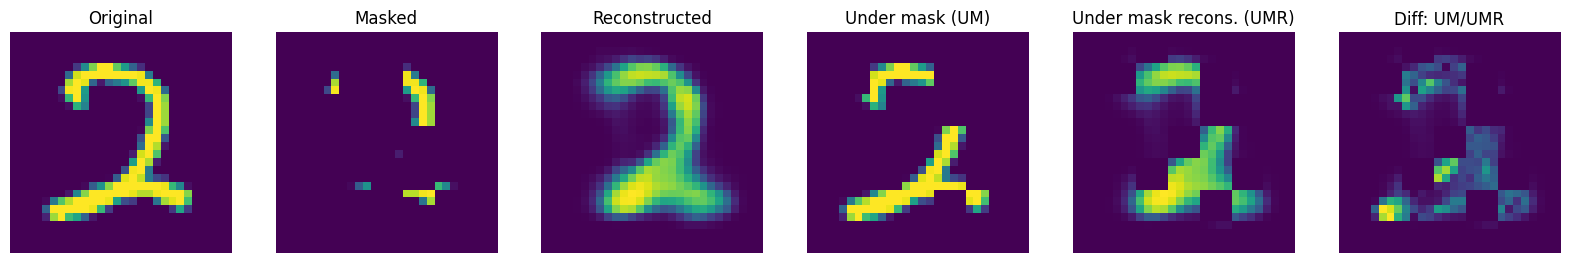

MSE - all patches: 0.0346922837
MSE - under the mask patches: 0.0328115076


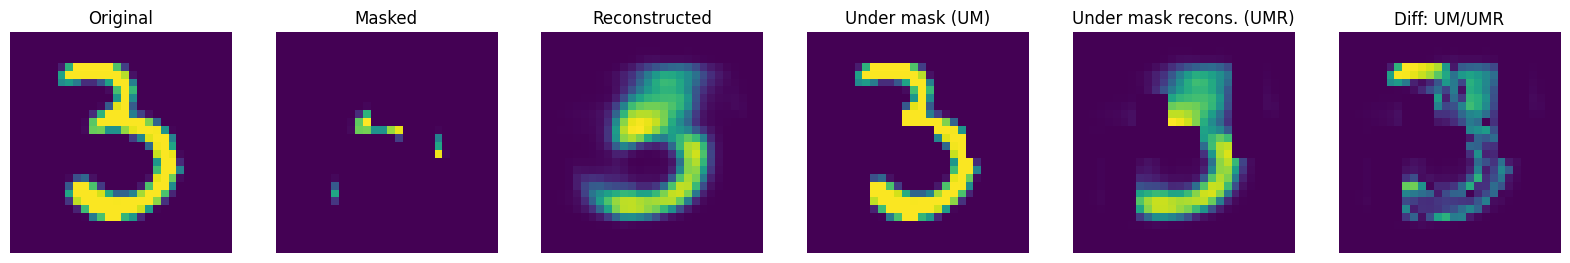

MSE - all patches: 0.046635896
MSE - under the mask patches: 0.0520424247


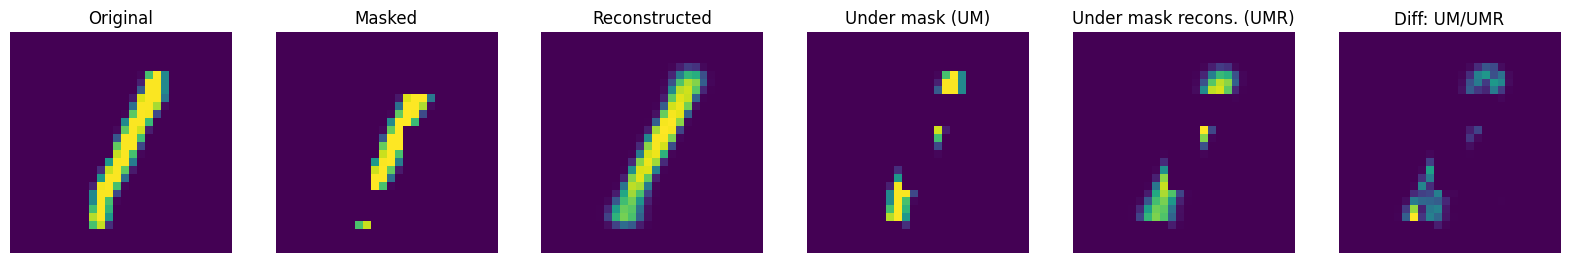

MSE - all patches: 0.00513408799
MSE - under the mask patches: 0.00443473225


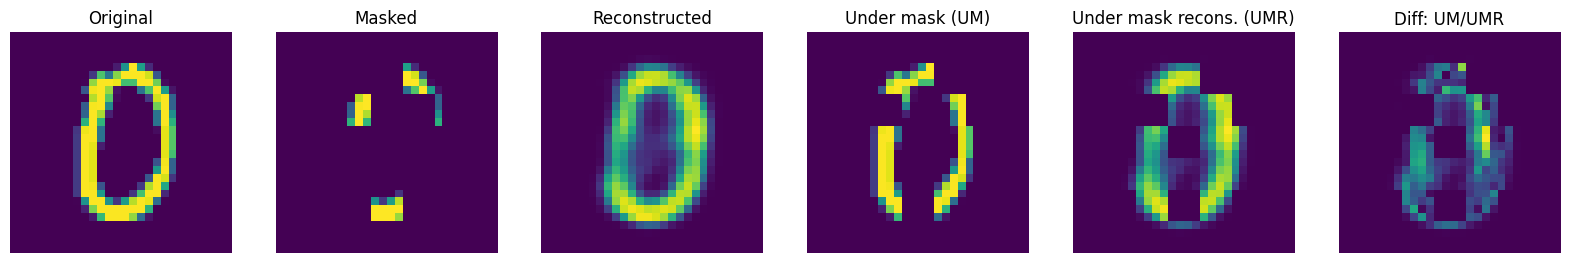

MSE - all patches: 0.0207640398
MSE - under the mask patches: 0.0239826124


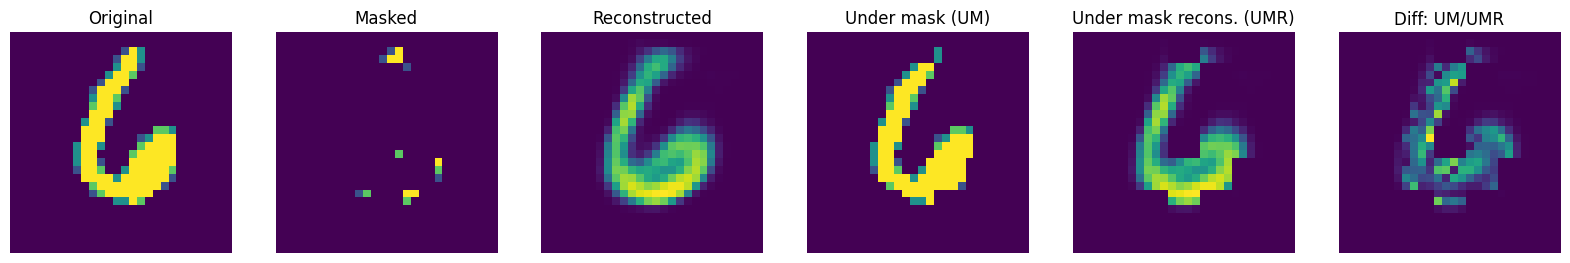

MSE - all patches: 0.0207986422
MSE - under the mask patches: 0.0241176225


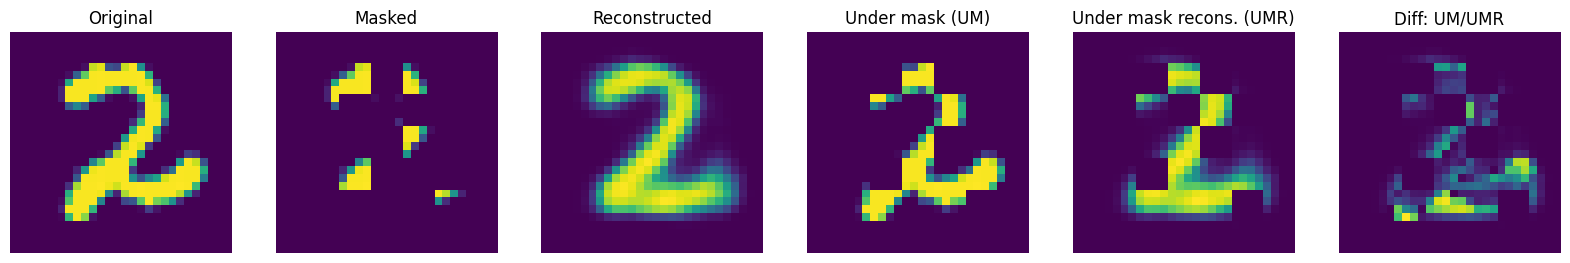

MSE - all patches: 0.0328265466
MSE - under the mask patches: 0.0362553895


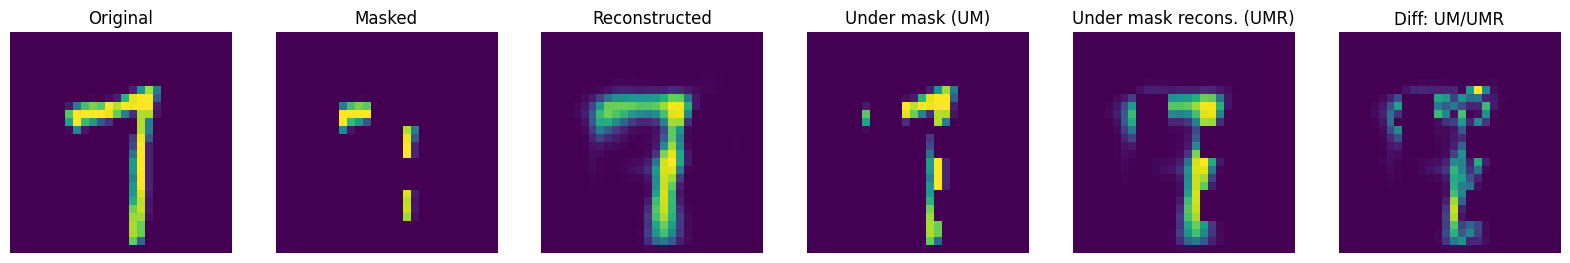

MSE - all patches: 0.014989526
MSE - under the mask patches: 0.0156848263


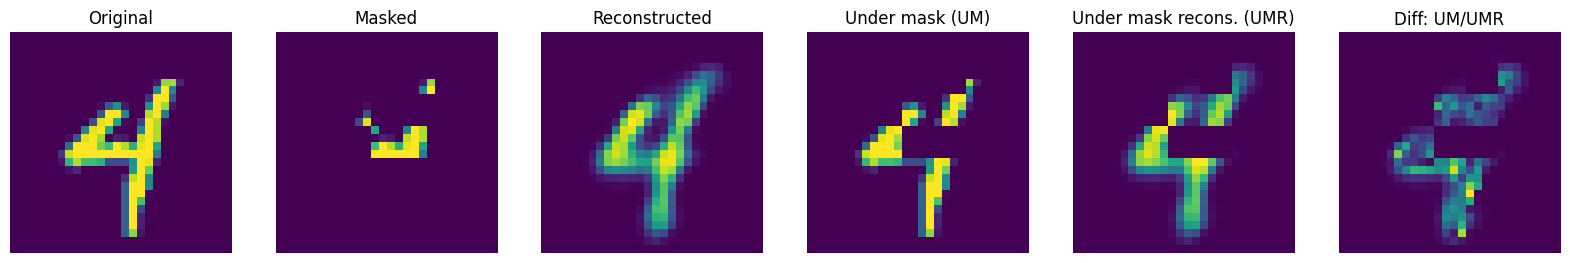

MSE - all patches: 0.0180281587
MSE - under the mask patches: 0.0162665024


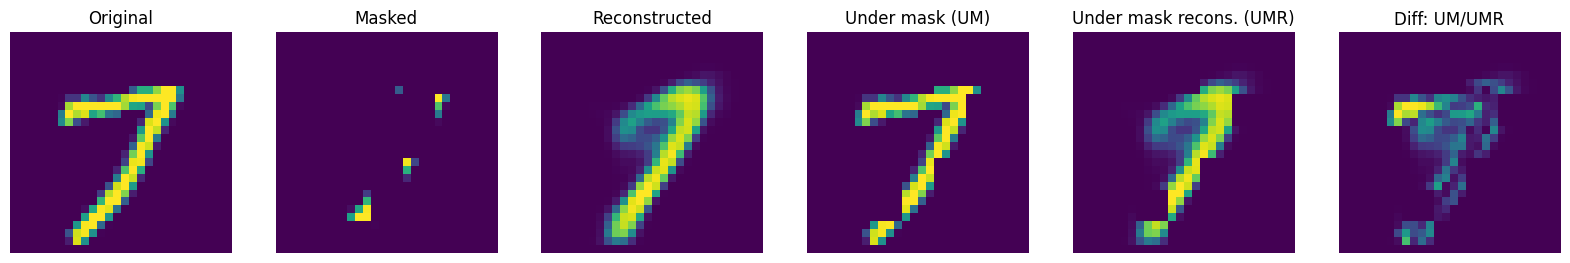

MSE - all patches: 0.0254098363
MSE - under the mask patches: 0.0326989852


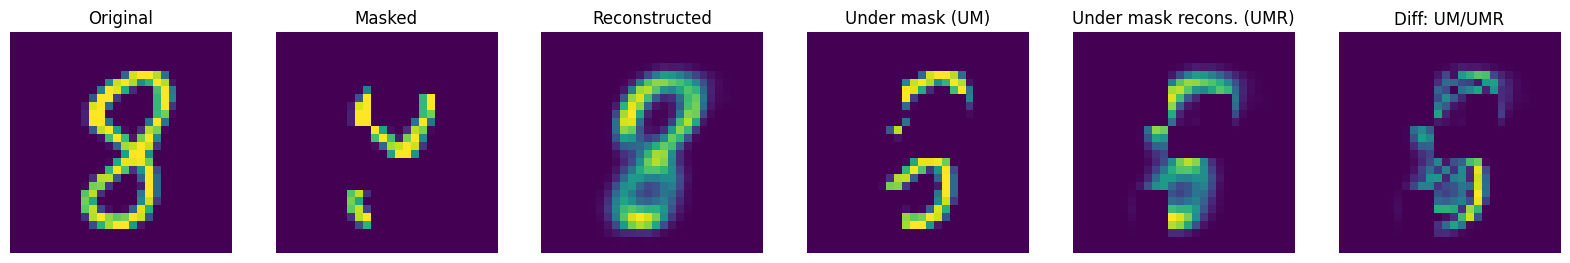

MSE - all patches: 0.0287828669
MSE - under the mask patches: 0.0266082827


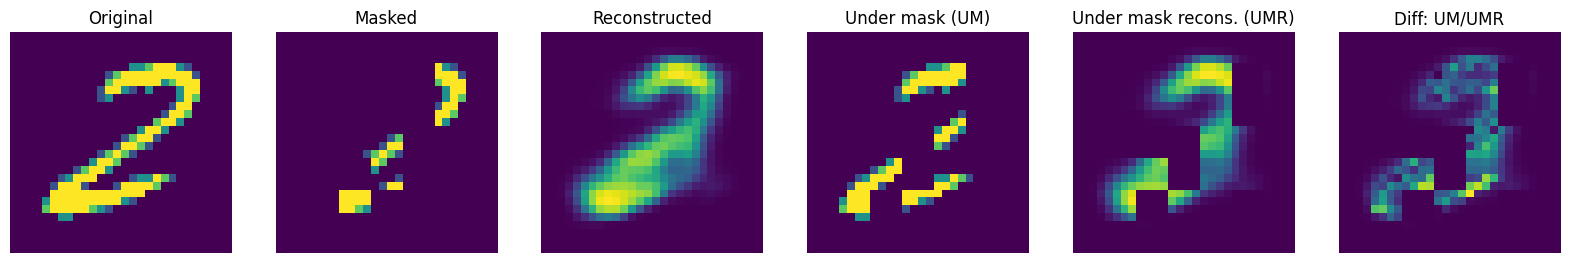

MSE - all patches: 0.0413195826
MSE - under the mask patches: 0.0309628639


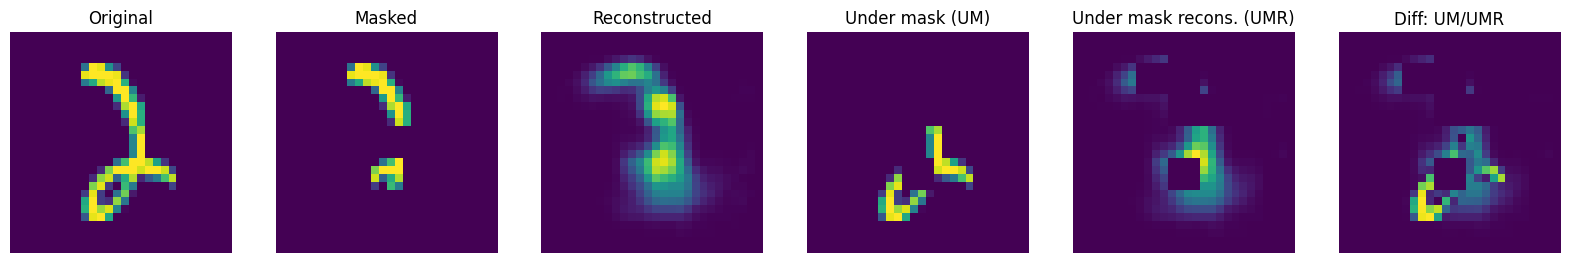

MSE - all patches: 0.0301999114
MSE - under the mask patches: 0.0293526519
---- Reconstruction error mean: all patches ----
MSE: 0.0287847035
---- Reconstruction error mean: under the mask patches ----
MSE: 0.0313624963


In [ ]:
MSE_rec = 0
MSE_under_mask = 0

for i in range(40):

  lenght = len(x_test)
  image_idx = random.randint(0,lenght-1)
  test_image = x_test[image_idx]

  test_patches = mae_model.patch_layer(test_image.reshape(1,28,28,1))
  (
      test_unmasked_embeddings,
      test_masked_embeddings,
      test_unmasked_positions,
      test_mask_indices,
      test_unmask_indices,
  ) = mae_model.patch_encoder(test_patches)
  test_encoder_outputs = mae_model.encoder(test_unmasked_embeddings)
  test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
  test_decoder_inputs = tf.concat(
      [test_encoder_outputs, test_masked_embeddings], axis=1
  )
  test_decoder_outputs = mae_model.decoder(test_decoder_inputs)
  test_decoder_patches = mae_model.patch_layer(test_decoder_outputs)

  test_loss_patch = tf.gather(test_patches, test_mask_indices, axis=1, batch_dims=1)
  test_loss_output = tf.gather(test_decoder_patches, test_mask_indices, axis=1, batch_dims=1)

  #####
  test_unmasked_patch, idx = mae_model.patch_encoder.generate_masked_image(
                  test_patches, test_mask_indices
              )

  unmasked_image = mae_model.patch_layer.reconstruct_from_patch(
      test_unmasked_patch
  )
  test_unmasked_output, idx = mae_model.patch_encoder.generate_masked_image(
                  test_decoder_patches, test_mask_indices
              )

  unmasked_output = mae_model.patch_layer.reconstruct_from_patch(
      test_unmasked_output
  )
  #####

  # Show a maksed patch image.
  test_masked_patch, idx = mae_model.patch_encoder.generate_masked_image(
      test_patches, test_unmask_indices
  )
  original_image = test_image
  masked_image = mae_model.patch_layer.reconstruct_from_patch(
      test_masked_patch
  )
  reconstructed_image = test_decoder_outputs[0]

  fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 3))
  ax[0].imshow(original_image)
  ax[0].set_title(f"Original")
  ax[0].axis("off")

  ax[1].imshow(masked_image)
  ax[1].set_title(f"Masked")
  ax[1].axis("off")

  ax[2].imshow(reconstructed_image)
  ax[2].set_title(f"Reconstructed")
  ax[2].axis("off")

  ax[3].imshow(unmasked_image)
  ax[3].set_title(f"Under mask (UM)")
  ax[3].axis("off")

  ax[4].imshow(unmasked_output)
  ax[4].set_title(f"Under mask recons. (UMR)")
  ax[4].axis("off")

  ax[5].imshow(abs(unmasked_output - unmasked_image))
  ax[5].set_title(f"Diff: UM/UMR")
  ax[5].axis("off")

  plt.show()
  plt.close()

  tf.print("MSE - all patches:",tf.keras.metrics.MeanSquaredError()(test_patches,test_decoder_patches))
  MSE_rec = MSE_rec + tf.keras.metrics.MeanSquaredError()(test_patches,test_decoder_patches)
  tf.print("MSE - under the mask patches:",tf.keras.metrics.MeanSquaredError()(test_loss_output,test_loss_patch))
  MSE_under_mask = MSE_under_mask + tf.keras.metrics.MeanSquaredError()(test_loss_output,test_loss_patch)

print("---- Reconstruction error mean: all patches ----")
tf.print("MSE:",MSE_rec/40)


print("---- Reconstruction error mean: under the mask patches ----")
tf.print("MSE:",MSE_under_mask/40)

